## Dataset: A databank for intracellular electrophysiological mapping of the adult somatosensory cortex

See https://github.com/OpenSourceBrain/NWBShowcase/issues/5

In [1]:
# import modules
from datetime import datetime, tzinfo, timedelta
import hdmf._version
from dateutil.tz import tzlocal
import platform
import math
import numpy as np
import uuid
import os
from os import environ
import scipy.io as sio
from hdmf.backends.hdf5.h5_utils import H5DataIO
import pandas as pd

#https://pypi.org/project/pyabf/
import pyabf

import pynwb
print('Using pynwb v%s'%pynwb.__version__)



Using pynwb v1.3.0


In [2]:
# User provided arguments
try:
    # if running build.py
    file_number = int(environ['file_number'])
    save_nwb = True 
    show_plots = False
    
except:
    # default values if viewing Notebook
    file_number = 0 
    save_nwb = False
    show_plots = True
    
    
save_plots = False



## Overview of all data sets

In [3]:
# 2 current clamps (CC), 2 voltage clamps (VC), and 2 saw-tooth (ST) 
# -- some files are mislabeled as VC but are ST
all_datarefs = ['180817_ME_9_CC','170502_AL_257_CC', # CC
               '170328_AL_238_VC','170315_AL_216_VC', # VC
               '171220_NC_156_ST100_C','170328_AB_277_ST50_C'] # ST



Notice in the following figures that the sweeps are out of order seen using matplotlib default colors. The first two colors should be blue and orange (in that order).

Contents of MAT file 180817_ME_9_CC.mat
10


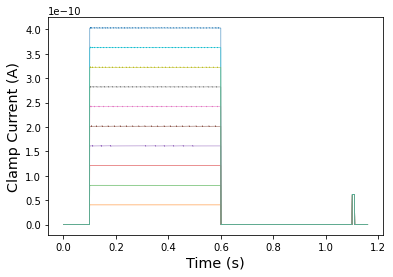

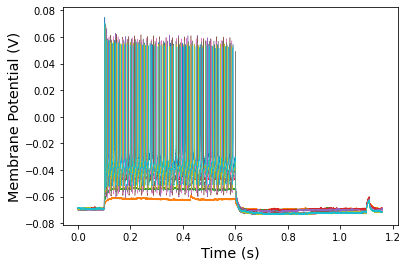

Contents of MAT file 170502_AL_257_CC.mat
30


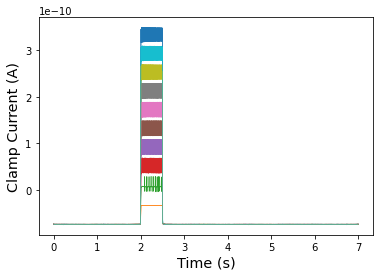

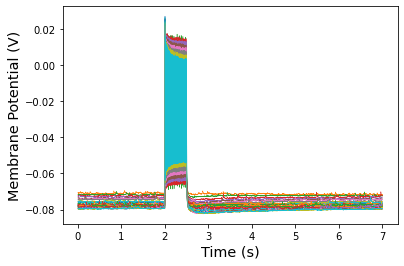

Contents of MAT file 170328_AL_238_VC.mat
14


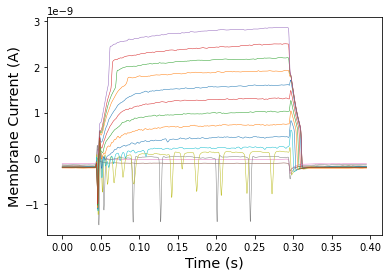

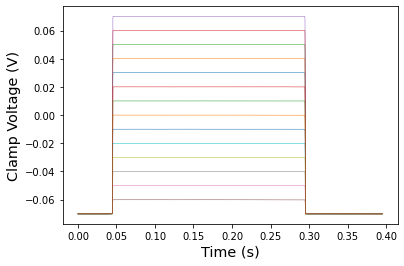

Contents of MAT file 170315_AL_216_VC.mat
14


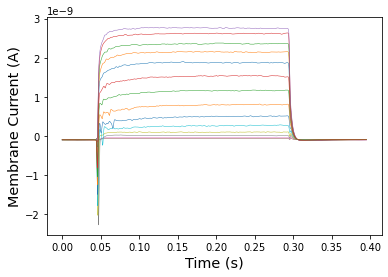

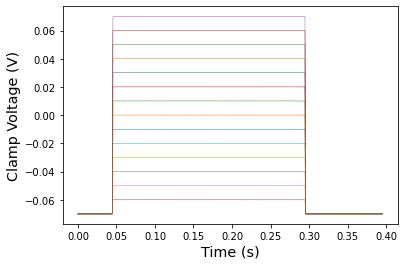

Contents of MAT file 171220_NC_156_ST100_C.mat
2


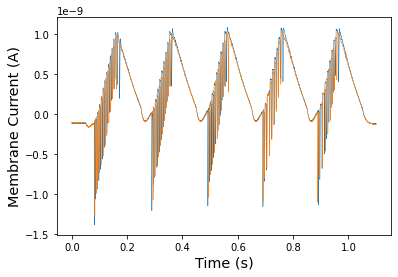

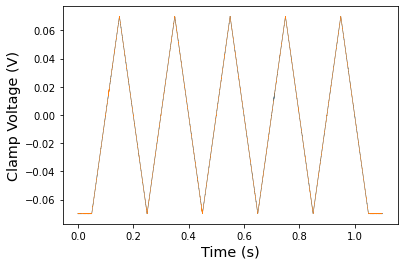

Contents of MAT file 170328_AB_277_ST50_C.mat
2


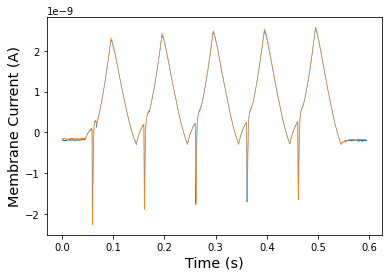

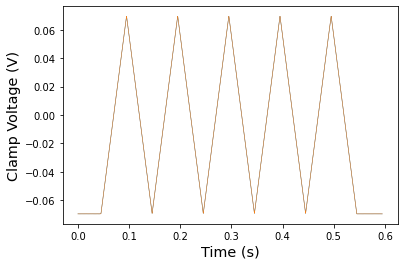

In [4]:
if show_plots:
    import matplotlib.pyplot as plt
    %matplotlib inline 


    # Get mat files from ftp://parrot.genomics.cn/gigadb/pub/10.5524/100001_101000/100535/CurrentClamp/StepProtocol/

    y_labels = [('Clamp Current (A)','Membrane Potential (V)'),('Clamp Current (A)','Membrane Potential (V)'),
                ('Membrane Current (A)','Clamp Voltage (V)'),('Membrane Current (A)','Clamp Voltage (V)'),
                ('Membrane Current (A)','Clamp Voltage (V)'),('Membrane Current (A)','Clamp Voltage (V)')]

    for i, data_ref in enumerate(all_datarefs):

        mat_file = '%s.mat'%data_ref
        mat_contents = sio.loadmat(mat_file)
        count = 0

        print('Contents of MAT file %s'%mat_file)

        key_set = sorted(mat_contents.keys())


        #### current ####
        fig = plt.figure()

        for t in key_set:
            if 'Trace_' in t and t.endswith('_1'):
                #print('Current injection trace: %s'%t)
                trace = mat_contents[t].T

                plt.plot(trace[0],trace[1], lw=.5, label='%s'%t)
                plt.ylabel(y_labels[i][0],size='x-large')
                plt.xlabel('Time (s)',size='x-large')


                count+=1
                

        print(count)
        if not save_plots:
            plt.show()

        else:
            fig_name = 'Lantyer_%s_current.png'%(str(i))
            fig_file = os.path.join('images',fig_name)
            fig.savefig(fig_file,bbox_inches='tight')    

            
            
        #### potential ###
        fig = plt.figure()


        for t in key_set:
            if 'Trace_' in t and t.endswith('_2'):
                #print('Response trace: %s'%t)
                trace = mat_contents[t].T

                plt.plot(trace[0],trace[1], lw=.5, label='%s'%t)
                plt.ylabel(y_labels[i][1],size='x-large')
                plt.xlabel('Time (s)',size='x-large')

        if not save_plots:
            plt.show()

        else:
            fig_name = 'Lantyer_%s_voltage.png'%(str(i))
            fig_file = os.path.join('images',fig_name)
            fig.savefig(fig_file,bbox_inches='tight')



## Global variables

In [5]:
delimiters = ['_CC','_CC','_VC','_VC','_ST100','_ST50']



In [6]:
# random UUID for globally unique tag
unique_identifier = str(uuid.uuid4())



In [7]:
# greek unicode
ohm = '\u03A9'
micro = '\u03BC'



## Upload subject metadata

In [8]:
# scraped from website
samples_df = pd.read_pickle('sample_metadata.pkl')



In [9]:
reduced_datarefs = [dr.split(delim)[0] for dr,delim in zip(all_datarefs,delimiters)]
these_sample_ids = [s for s in samples_df['Sample ID'].tolist() if s in reduced_datarefs]
metadata_df = samples_df[samples_df['Sample ID'].isin(these_sample_ids)]



In [10]:
# metadata from website
metadata_df.head()



,Sample ID,Taxonomic ID,Common Name,Genbank Name,Scientific Name,Description,Age,Sex,Collection date
40,170315_AL_216,10090,Mouse,house mouse,Mus musculus,Electrophysiology of the primary somatosensory...,276 days postnatal,F,2017-03-15
54,170328_AB_277,10090,Mouse,house mouse,Mus musculus,Electrophysiology of the primary somatosensory...,316 days postnatal,M,2017-03-28
59,170328_AL_238,10090,Mouse,house mouse,Mus musculus,Electrophysiology of the primary somatosensory...,316 days postnatal,M,2017-03-28
82,170502_AL_257,10090,Mouse,house mouse,Mus musculus,Electrophysiology of the primary somatosensory...,248 days postnatal,F,2017-05-02
287,171220_NC_156,10090,Mouse,house mouse,Mus musculus,Electrophysiology of the primary somatosensory...,218 days postnatal,F,2017-12-20


In [11]:
# import example file
data_ref = all_datarefs[file_number]
delimiter = delimiters[file_number]

mat_file = '%s.mat'%data_ref
mat_contents = sio.loadmat(mat_file) # Has minimal metadata

reduced_dataref = data_ref.split(delimiter)[0]
meta_df = metadata_df[metadata_df['Sample ID']==reduced_dataref]

# make comments from header before removing
comments='Extracted from: %s.mat, '%data_ref
comments = comments + mat_contents['__header__'].decode("utf-8")



In [12]:
# remove all items in mat_contents that aren't data
temp = mat_contents.copy()

for key in temp.keys():  
    if not 'Trace_' in key:
        mat_contents.pop(key)
        
        

In [13]:
# pad sweep number (c) for all trace names
# NOTE: This is to sort keys so that they follow the sweep order
temp = mat_contents.copy()
for key in temp.keys():
    
    [trace,a,b,c,d] = key.split('_')
    if int(c)<10:
        c = '0'+c # pad with zero
    
        # replace items with padded items
        data = mat_contents[key]
        new_key = trace+'_'+a+'_'+b+'_'+c+'_'+d
        mat_contents[new_key] = data
        mat_contents.pop(key)



In [14]:
# protocol-specific information
if 'CC' in delimiter:
    
    from pynwb.icephys import CurrentClampStimulusSeries as stimulus_series
    from pynwb.icephys import CurrentClampSeries as acquisition_series
    
    protocol = 'step-and-hold stimulation protocol'
    
    stimulus_name = 'CurrentClampStimulusSeries'
    acquistion_name = 'CurrentClampSeries'
    
    var = 'current'
    units = 'pA'
    step_size = 40.
     
    stim_notes = ('10 depolarizing 40pA current steps '
          'of 500ms duration pulses'
          'with inter-sweep intervals of 6.5s, '
          'stimulus repeated 1-3 times ' 
          'within 20s interval, resting membrane potential '
          'set to -70mV by somatic current injection') 
    
    
elif 'VC' in delimiter:
    from pynwb.icephys import VoltageClampStimulusSeries as stimulus_series
    from pynwb.icephys import VoltageClampSeries as acquisition_series
    
    protocol = 'step-and-hold stimulation protocol'

    stimulus_name = 'VoltageClampStimulusSeries'
    acquistion_name = 'VoltageClampSeries'
    
    var = 'voltage'
    units = 'mV'
    step_size = 10.
    volt_offset = -70. # voltage initially held at resting membrane potential
    
    stim_notes = ('14 depolarizing 10mV voltage steps '
          'of 250ms duration pulses within 20s interval, '
          'membrane potential clamped at -70mV prior to depolarization')


else:
    from pynwb.icephys import VoltageClampStimulusSeries as stimulus_series
    from pynwb.icephys import VoltageClampSeries as acquisition_series

    protocol =  'Sawtooth'
    
    stimulus_name = 'VoltageClampStimulusSeries'
    acquistion_name = 'VoltageClampSeries'
    
    units = 'mV'
    
    frequency = data_ref.split('_')[-2].split('ST')[-1]
    
    # hard-coded descrepancy between file name and visually inspected frequency
    if int(frequency)==100:
        frequency = 5
    else:
        frequency = 10
    
    stim_notes = ('5 triangular pulse injections, ranging '
          'from -70 to 70 mV delivered at inter-peak frequency of %s Hz, '
          'of duration 1s, repeated twice within 20s interval, '
          'membrane potential clamped at -70mV prior to depolarization')%frequency



In [15]:
# date and time information
create_date = datetime.now(tz=tzlocal()) 

date = meta_df['Collection date'].iloc[0]
date = date.split('-')

year, month, day = int(date[0]), int(date[1]), int(date[2])

# for Nijmegen, Netherlands
class TZ(tzinfo):
    def utcoffset(self, dt):
        return timedelta(hours=2)
    def dst(self, dt):
        return timedelta(1) # 0 if not DST, 1 if DST
    def tzname(self,dt):
        return "+02:00"
    def  __repr__(self):
        return f"{self.__class__.__name__}()"
    
start_time = datetime(year,month,day,tzinfo=TZ())



In [16]:
# subject-related elements
species = meta_df['Scientific Name'].iloc[0]
sex = meta_df['Sex'].iloc[0]
age= meta_df['Age'].iloc[0].split(' ')[0]

subject = pynwb.file.Subject(
    species = species,
    genotype='Pvalbtm1(cre)Arbr or Ssttm2.1(cre)Zjh',
    sex = sex,
    age = 'P'+age+'D'
)

In [17]:
# create main file elements
# reference = 'LantyerEtAl2018'

hdmf_ver = 'v%s'%hdmf._version.get_versions()['version']
notes = 'NWB2 file with ephys created with pynwb v%s (HDMF %s) and Python %s' %(pynwb.__version__,hdmf_ver,platform.python_version())

session_description = data_ref 
description = meta_df['Description'].iloc[0]

experimenter = 'Angelica da Silva Lantyer' if 'AL' in data_ref else \
               ('Niccolò Calcini' if 'NC' in data_ref else \
                ('Ate Bijlsma' if 'AB' in data_ref else \
                ('Melanie Emmelkamp' if 'ME' in data_ref else '???')))

keywords=['whole-cell intracellular recordings','somatic patch-clamp',
          'current-clamp','voltage-clamp','acute brain slices',
          'adult brain','barrel cortex','frozen noise','big data']



In [18]:
nwbfile = pynwb.NWBFile(
            session_description=session_description,
            identifier=unique_identifier,
            session_start_time=start_time,
            file_create_date=create_date,
            notes=notes,
            experimenter=experimenter,
            institution='Donders Institute for Brain, Cognition and Behaviour, Radboud University',
            experiment_description=description,
    
            # subject-related field
            subject=subject,
            slices=('coronal slices of primary somatosensory cortex '
                   '(300 %sm thickness) in ice-cold perfusion')%micro,
    
            # recording-related fields
            protocol=protocol,
            stimulus_notes=stim_notes,
            keywords=keywords
    
)



In [19]:
# device metadata
device = nwbfile.create_device(name='device',
                            description=('HEKA EPC 9 and EPC10 amplifiers, '
                                         'Patch Master v2 x 90.2 software'),
                            manufacturer='HEKA Elektronik, Holliston, MA'
            )

slice_prep = 'coronal slice'
location = 'supragranular layer, S1, barrel subfield region'

electrode = nwbfile.create_icephys_electrode(name='icephys_electrode',
                            description=('Patch clamp electrodes pulled from '
                                         'glass capillaries (5-10 M%s)')%ohm,
                            slice=slice_prep,
                            location=location,
                            device=device,
)



## Sweep-specific information

In [20]:
# initialize step count for arbitrary steps
stim_sweep_number = 1
acq_sweep_number = 1

# sort by sweep number
these_keys = sorted(list(mat_contents.keys()))

for i, t in enumerate(these_keys):
        
    if delimiter in ['_CC']:
        # current clamp could be repeated 1-3 times (i.e., 10, 20 or 30 traces)
        if stim_sweep_number%10==0:
            injection = 10*step_size
        else:
            injection = stim_sweep_number%10*step_size
            
        description = ('Sweep %i, applied %s '
                        '(pulse ~%s%s)')%(stim_sweep_number,var,injection,units)

    elif delimiter in ['_VC']:
        injection = stim_sweep_number * step_size + volt_offset
        description = ('Sweep %i, applied %s '
                        '(held at ~%s%s)')%(stim_sweep_number,var,injection,units)
    else:
        description = ('Sweep %i, sawtooth injection '
                       '(triangular pulses at %sHz)')%(stim_sweep_number,frequency)

    print('Adding trace: %s'%t)
    trace = mat_contents[t].T
    timestamps = trace[0]
    data = trace[1] 

    wrapped_data = H5DataIO(data=data, compression=True) 


    # switch which Trace_? is input variable
    if delimiter in ['_CC']:
        end = '_1'
        unit = 'amperes'
    else:
        end = '_2'
        unit = 'volts'

    if t.endswith(end):

        conversion = 1.0
        gain = 1. # Unspecified, placeholder

        sts = stimulus_series(
             name=stimulus_name+'_%s'%(stim_sweep_number    ## As a default, name class instances with the same name as the class  
                                        if stim_sweep_number>9
                                        else '0'+str(stim_sweep_number)),             
             description=description,
             stimulus_description=protocol,
             sweep_number=stim_sweep_number,

             data=wrapped_data,
             timestamps=timestamps,
             unit=unit,
             conversion=conversion,

             electrode=electrode,
             gain=gain,

             comments=comments
        )

        # Update NWB File
        nwbfile.add_stimulus(sts)

        # increment sweep count
        stim_sweep_number+=1


    conversion = 1.0
    gain = 1.0 # Unspecified, placeholder

    # switch which Trace_? is response variable
    if delimiter in ['_CC']:
        end = '_2'
        unit = 'volts'
    else:
        end = '_1'
        unit = 'amperes'


    if t.endswith(end):
        acs = acquisition_series(
             name=acquistion_name+'_%s'%(acq_sweep_number      ## As a default, name class instances with the same name as the class
                                        if acq_sweep_number>9
                                        else '0'+str(acq_sweep_number)),
             description=description,
             stimulus_description=protocol,
             sweep_number=acq_sweep_number,

             data=wrapped_data,
             timestamps=timestamps,
             unit=unit,
             conversion=conversion,

             electrode=electrode,
             gain=gain,

             comments=comments
        )

        # Update NWB File
        nwbfile.add_acquisition(acs)

        # increment sweep count
        acq_sweep_number+=1


Adding trace: Trace_9_1_01_1
Adding trace: Trace_9_1_01_2
Adding trace: Trace_9_1_02_1
Adding trace: Trace_9_1_02_2
Adding trace: Trace_9_1_03_1
Adding trace: Trace_9_1_03_2
Adding trace: Trace_9_1_04_1
Adding trace: Trace_9_1_04_2
Adding trace: Trace_9_1_05_1
Adding trace: Trace_9_1_05_2
Adding trace: Trace_9_1_06_1
Adding trace: Trace_9_1_06_2
Adding trace: Trace_9_1_07_1
Adding trace: Trace_9_1_07_2
Adding trace: Trace_9_1_08_1
Adding trace: Trace_9_1_08_2
Adding trace: Trace_9_1_09_1
Adding trace: Trace_9_1_09_2
Adding trace: Trace_9_1_10_1
Adding trace: Trace_9_1_10_2


In [21]:
if save_nwb:
    nwb_file_name = 'LantyerEtAl2018_%s.nwb'%(data_ref)
    
    
    io = pynwb.NWBHDF5IO(nwb_file_name, mode='w')
    io.write(nwbfile)
    io.close()
    print("%s: %s"%(notes,nwb_file_name))

## To check NWB file

In [23]:
import sys
sys.path.append("../NWB")

import nwb_info

nwb_file_name = 'LantyerEtAl2018_%s.nwb'%(data_ref)
nwb_info.print_info(nwb_file_name)



NWB info
  Info on Python (v3.7.6) packages:
    PIL                 (installed: v7.1.2)
    av                  (installed: ???)
    dateutil            (installed: v2.8.1)
    h5py                (installed: ???)
    hdf5                (installed: ???)
    hdmf                (installed: v1.6.1)
    imageio             (installed: v2.8.0)
    numpy               (installed: v1.18.1)
    pandas              (installed: v1.0.3)
    pillow              (installed: ???)
    pyabf               (installed: v2.2.4)
    pynwb               (installed: v1.3.0)
    scipy               (installed: v1.4.1)
    six                 (installed: v1.14.0)
    tifffile            (installed: v2020.6.3)

Info on LantyerEtAl2018_180817_ME_9_CC.nwb (4619469 bytes; modified: Sat Jul 11 13:32:05 2020)
    Attr   .specloc =	 <HDF5 object reference>
    Attr   namespace =	 core
    Attr   neurodata_type =	 NWBFile
    Attr   nwb_version =	 2.2.2
    Attr   object_id =	 72a698ed-2ef7-475c-8878-912aad28f372


        neurodata_type = 	CurrentClampSeries 
        object_id = 	02f029f0-b973-4551-ab64-a054c8b94539 
        stimulus_description = 	step-and-hold stimulation protocol 
        sweep_number = 	10 
    /acquisition/CurrentClampSeries_10/data = 	ndarray: [-0.0693 -0.0698 -0.0694 ... -0.0712 -0.0718 -0.0715]
        conversion = 	1.0 
        resolution = 	-1.0 
        unit = 	volts 
    /acquisition/CurrentClampSeries_10/electrode
        namespace = 	core 
        neurodata_type = 	IntracellularElectrode 
        object_id = 	20aa4cc3-4b80-4d8f-8da9-b3467c20b627 
    /acquisition/CurrentClampSeries_10/electrode/description = 	'Patch clamp electrodes pulled from glass capillaries (5-10 MΩ)'
    /acquisition/CurrentClampSeries_10/electrode/device
        namespace = 	core 
        neurodata_type = 	Device 
        object_id = 	247c03d1-c983-42fd-877c-9a76ace3b667 
    /acquisition/CurrentClampSeries_10/electrode/location = 	'supragranular layer, S1, barrel subfield region'
    /acqui

    /stimulus/presentation/CurrentClampStimulusSeries_09/data = 	ndarray: [ 0.  0.  0. ... -0.  0.  0.]
        conversion = 	1.0 
        resolution = 	-1.0 
        unit = 	amperes 
    /stimulus/presentation/CurrentClampStimulusSeries_09/electrode
        namespace = 	core 
        neurodata_type = 	IntracellularElectrode 
        object_id = 	20aa4cc3-4b80-4d8f-8da9-b3467c20b627 
    /stimulus/presentation/CurrentClampStimulusSeries_09/electrode/description = 	'Patch clamp electrodes pulled from glass capillaries (5-10 MΩ)'
    /stimulus/presentation/CurrentClampStimulusSeries_09/electrode/device
        namespace = 	core 
        neurodata_type = 	Device 
        object_id = 	247c03d1-c983-42fd-877c-9a76ace3b667 
    /stimulus/presentation/CurrentClampStimulusSeries_09/electrode/location = 	'supragranular layer, S1, barrel subfield region'
    /stimulus/presentation/CurrentClampStimulusSeries_09/electrode/slice = 	'coronal slice'
    /stimulus/presentation/CurrentClampStimulusSeri

root pynwb.file.NWBFile at 0x140643962623504
Fields:
  acquisition: {
    CurrentClampSeries_01 <class 'pynwb.icephys.CurrentClampSeries'>,
    CurrentClampSeries_02 <class 'pynwb.icephys.CurrentClampSeries'>,
    CurrentClampSeries_03 <class 'pynwb.icephys.CurrentClampSeries'>,
    CurrentClampSeries_04 <class 'pynwb.icephys.CurrentClampSeries'>,
    CurrentClampSeries_05 <class 'pynwb.icephys.CurrentClampSeries'>,
    CurrentClampSeries_06 <class 'pynwb.icephys.CurrentClampSeries'>,
    CurrentClampSeries_07 <class 'pynwb.icephys.CurrentClampSeries'>,
    CurrentClampSeries_08 <class 'pynwb.icephys.CurrentClampSeries'>,
    CurrentClampSeries_09 <class 'pynwb.icephys.CurrentClampSeries'>,
    CurrentClampSeries_10 <class 'pynwb.icephys.CurrentClampSeries'>
  }
  devices: {
    device <class 'pynwb.device.Device'>
  }
  experiment_description: Electrophysiology of the primary somatosensory cortex in adult mice. Current clamp step and hold (CC) lamp 40pA
  experimenter: ['Melanie Emmel